In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [5]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

(70000, 784)
<class 'numpy.ndarray'>


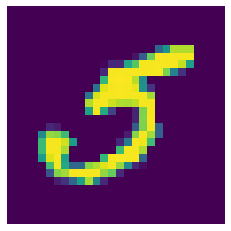

In [6]:
X, y = mnist["data"], mnist["target"]

print(X.shape)
print(type(X))

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.axis("off")

plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [1, 5, 10]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 110.0min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 112.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': [1, 5, 10],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [23]:
cvres = grid_search.cv_results_
for score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(score, params)
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9719166666666667 {'n_neighbors': 1, 'weights': 'uniform'}
0.9719166666666667 {'n_neighbors': 1, 'weights': 'distance'}
0.9705333333333334 {'n_neighbors': 5, 'weights': 'uniform'}
0.97205 {'n_neighbors': 5, 'weights': 'distance'}
0.9669166666666666 {'n_neighbors': 10, 'weights': 'uniform'}
0.9690666666666666 {'n_neighbors': 10, 'weights': 'distance'}


0.9691

In [26]:
X_train.shape

(60000, 784)

In [42]:
from scipy.ndimage.interpolation import shift
from scipy.ndimage.interpolation import rotate

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx])
    return shifted_image.reshape([-1])

def rotate_image(image, angle):
    image = image.reshape((28, 28))
    rotated_image = rotate(image, angle, reshape=False)
    return rotated_image.reshape([-1])

def augmentation(X_train, y_train):
    X_train_augmented = [image for image in X_train]
    y_train_augmented = [label for label in y_train]
    
    for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
        for image, label in zip(X_train, y_train):
            X_train_augmented.append(shift_image(image, dx, dy))
            y_train_augmented.append(label)
    for angle in (5, -5, 10, -10):
        for image, label in zip(X_train, y_train):
            X_train_augmented.append(rotate_image(image, angle))
            y_train_augmented.append(label)

    return np.array(X_train_augmented), np.array(y_train_augmented)
    
X_train_augmented, y_train_augmented = augmentation(X_train, y_train)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

KeyboardInterrupt: 

In [39]:
X_train_augmented.shape

(540000, 784)

In [40]:
image = X_train[1000]
image = image.reshape((28, 28))
rotated_image = rotate(image, 10, reshape=False)
rotated_image2 = rotate(image, -5, reshape=False)
print(image.shape)
print(rotated_image.shape)
print(rotated_image2.shape)

(28, 28)
(28, 28)
(28, 28)


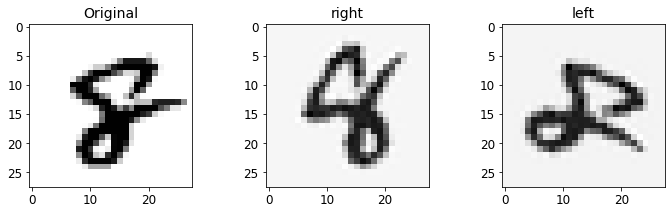

In [44]:
image = X_train[1000]
rotated_image_right = rotate_image(image, 40)
rotated_image_left = rotate_image(image, -40)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("right", fontsize=14)
plt.imshow(rotated_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("left", fontsize=14)
plt.imshow(rotated_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()